In [143]:
import numpy as np
import pandas as pd

file_path = "PUB_DemandZonal_2021.csv"
data = pd.read_csv(file_path)

In [144]:
# Convert the format of the data
df_cleaned = data.iloc[3:].reset_index(drop=True)
df_cleaned.columns = ["Date", "Hour", "Ontario Demand", "Northwest", "Northeast", "Ottawa",
                      "East", "Toronto", "Essa", "Bruce", "Southwest", "Niagara", "West", "Zone Total", "Diff"]
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"])
df_cleaned["Hour"] = pd.to_numeric(df_cleaned["Hour"])

# Create a timestamp column for better time series analysis
df_cleaned["Timestamp"] = df_cleaned.apply(lambda row: row["Date"] + pd.to_timedelta(row["Hour"] - 1, unit="h"), axis=1)


In [145]:
demand_columns = ["Ontario Demand", "Northwest", "Northeast", "Ottawa", "East", "Toronto",
                  "Essa", "Bruce", "Southwest", "Niagara", "West", "Zone Total", "Diff"]
df_cleaned[demand_columns] = df_cleaned[demand_columns].apply(pd.to_numeric, errors="coerce")

# Firstly analyze the Ontario Demand
df_entire = df_cleaned[["Timestamp", "Ontario Demand", "Zone Total"]]
df_entire.to_csv("Ontario_Demand.csv", index=False)


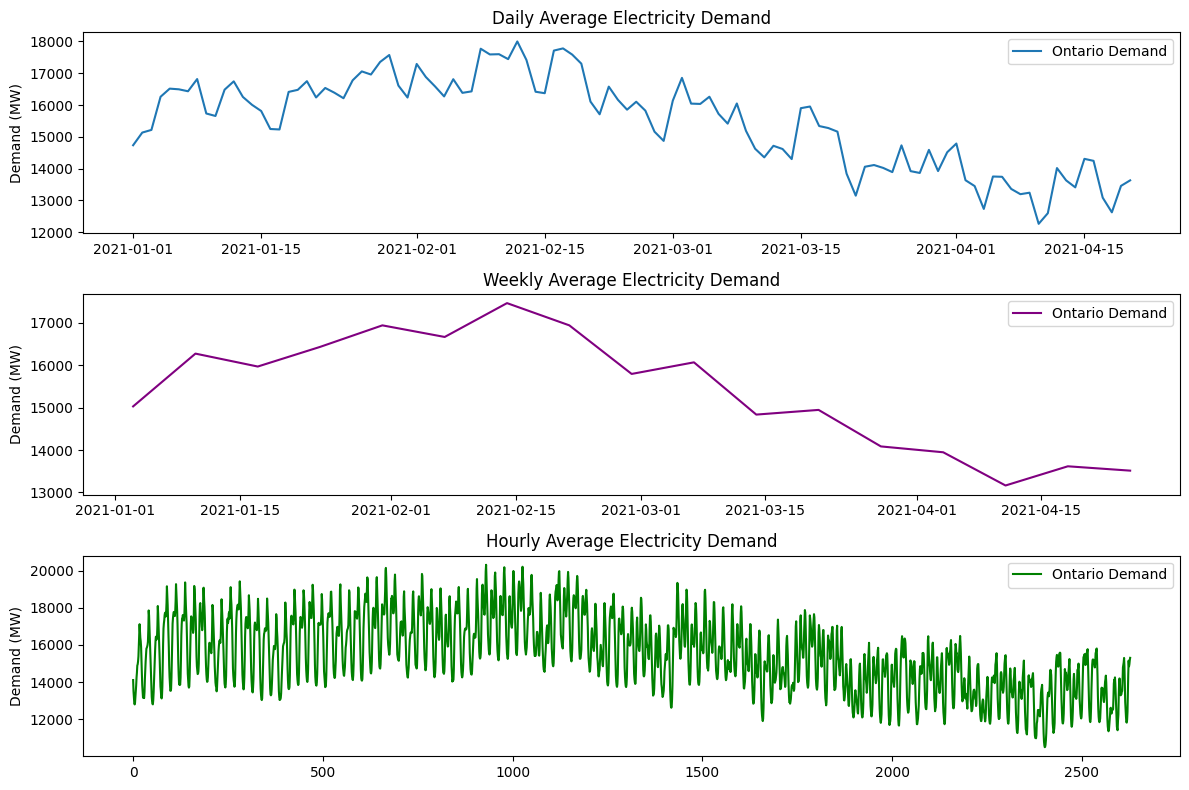

In [146]:
# Plot hourly, daily and weekly demand trends
import matplotlib.pyplot as plt

#only using 30% of the data for visualization
df_entire = df_entire.head(int(len(df_entire) * 0.3))
df_daily = df_entire.resample("D", on="Timestamp").mean()
df_weekly = df_entire.resample("W", on="Timestamp").mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Daily trend
axes[0].plot(df_daily.index, df_daily["Ontario Demand"], label="Ontario Demand", linewidth=1.5)
axes[0].set_title("Daily Average Electricity Demand")
axes[0].set_ylabel("Demand (MW)")
axes[0].legend()

# Weekly trend
axes[1].plot(df_weekly.index, df_weekly["Ontario Demand"], label="Ontario Demand", linewidth=1.5, color="purple")
axes[1].set_title("Weekly Average Electricity Demand")
axes[1].set_ylabel("Demand (MW)")
axes[1].legend()

#Hourly trend
axes[2].plot(df_entire.index, df_entire["Ontario Demand"], label="Ontario Demand", linewidth=1.5, color="green")
axes[2].set_title("Hourly Average Electricity Demand")
axes[2].set_ylabel("Demand (MW)")
axes[2].legend()

plt.tight_layout()
plt.show()

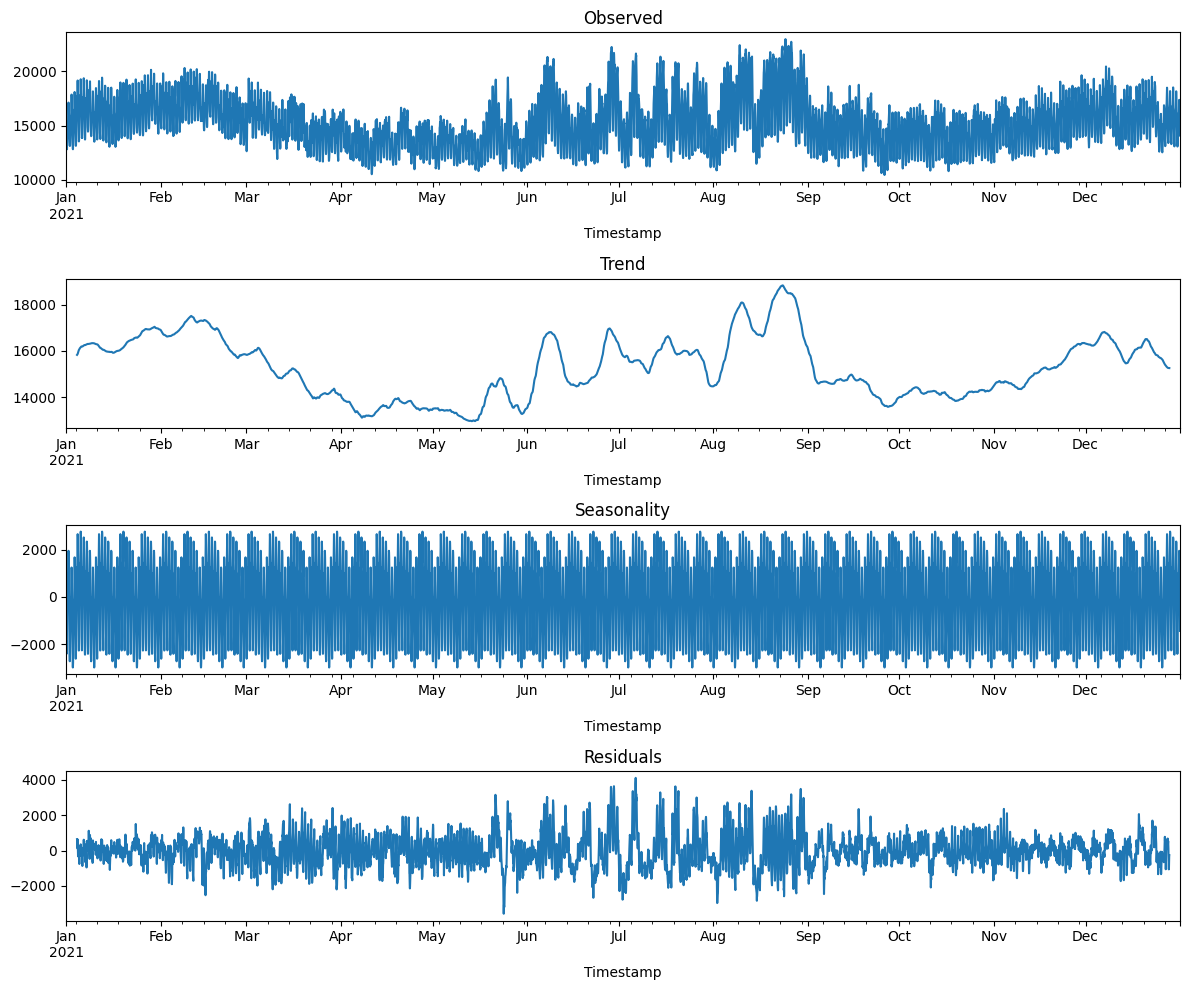

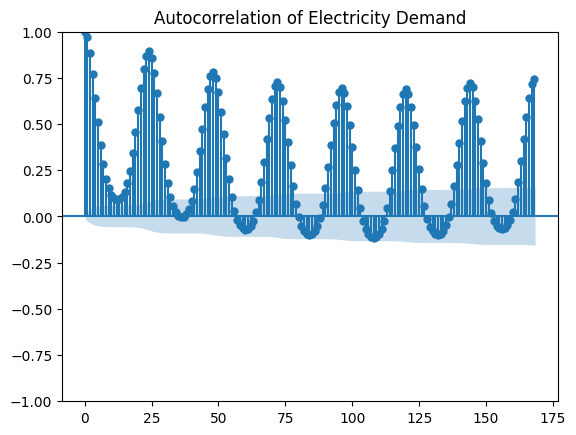

In [147]:
# See the seasonal trend 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_cleaned.set_index("Timestamp")["Ontario Demand"], model="additive", period=7*24)

# Plot seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show()

# Plot autocorrelation function to check seasonality
plot_acf(df_cleaned["Ontario Demand"], lags=168)  # Checking for weekly seasonality (7 days * 24 hours)
plt.title("Autocorrelation of Electricity Demand")
plt.show()


## AR Model


In [148]:
df_cleaned.columns
data_AR = df_cleaned[["Hour","Ontario Demand","Timestamp"]]
data_AR.set_index('Timestamp',inplace=True)
data_AR.head()

,Hour,Ontario Demand
Timestamp,,
2021-01-01 00:00:00,1,14112
2021-01-01 01:00:00,2,13504
2021-01-01 02:00:00,3,13155
2021-01-01 03:00:00,4,12892
2021-01-01 04:00:00,5,12798


In [149]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error

# Prepare the time series
demand_series = data_AR['Ontario Demand'].values
hours = data_AR['Hour'].values

# Split into train/test
split_idx = int(0.8 * len(demand_series))
train_series = demand_series[:split_idx]
test_series = demand_series[split_idx:]
train_hours = hours[:split_idx]
test_hours = hours[split_idx:]

# Redefine lag structure
def get_Lh(hour):
    return [24, 48, 72] if hour <= 7 else [48, 72, 96]

weekly_lags = [168 * i for i in range(1, 7)]  # Weekly lags
daily_lags = [24, 48, 72, 96]

# Evaluate AR model on a series using fixed lags
def evaluate_ar_on_split(alpha_lags, alpha_weekly, series, hours, start_idx):
    forecasts = []
    targets = []
    for t in range(start_idx, len(series)):
        hour = hours[t]
        Lh = get_Lh(hour)
        try:
            daily_sum = sum(alpha_lags.get(l, 0) * series[t - l] for l in Lh)
            weekly_sum = sum(alpha_weekly.get(l, 0) * series[t - l] for l in weekly_lags)
            y_hat = daily_sum + weekly_sum
            forecasts.append(y_hat)
            targets.append(series[t])
        except IndexError:
            continue
    return mean_absolute_error(targets, forecasts), forecasts, targets

# Grid search parameters
param_grid = {
    'alpha_24': [0.1, 0.2, 0.3, 0.4, 0.5],
    'alpha_48': [0.1, 0.2, 0.3, 0.4, 0.5],
    'alpha_72': [0.1, 0.2, 0.3],
    'alpha_96': [0.0, 0.1, 0.2],
    'alpha_weekly': [0.01, 0.03, 0.05]
}

grid = list(ParameterGrid(param_grid))
results = []

start_train = max(weekly_lags + [96])
for params in grid:
    alpha_lags = {
        24: params['alpha_24'],
        48: params['alpha_48'],
        72: params['alpha_72'],
        96: params['alpha_96']
    }
    alpha_weekly = {lag: params['alpha_weekly'] for lag in weekly_lags}
    mae, _, _ = evaluate_ar_on_split(alpha_lags, alpha_weekly, train_series, train_hours, start_train)
    results.append((params, mae))

# Select best hyperparameters
best_params, best_mae = min(results, key=lambda x: x[1])
best_params, best_mae


({'alpha_24': 0.2,
  'alpha_48': 0.4,
  'alpha_72': 0.1,
  'alpha_96': 0.2,
  'alpha_weekly': 0.05},
 1084.58635)

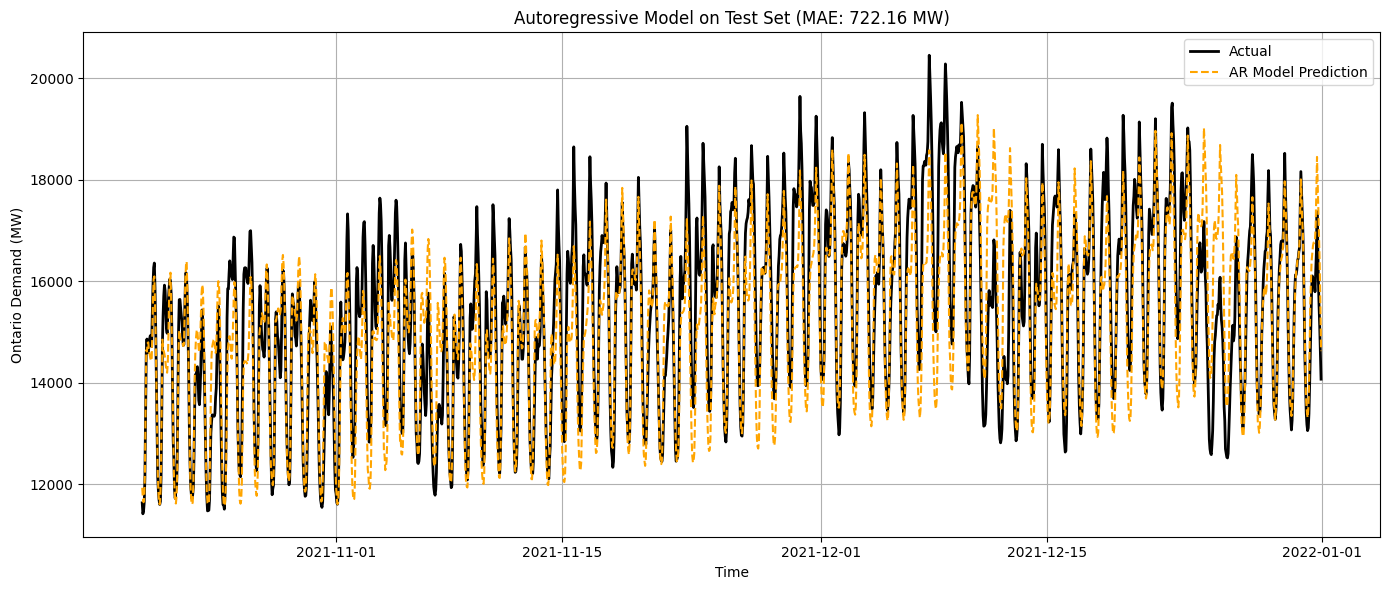

In [150]:
best_alpha_lags = {
    24: best_params['alpha_24'],
    48: best_params['alpha_48'],
    72: best_params['alpha_72'],
    96: best_params['alpha_96']
}
best_alpha_weekly = {lag: best_params['alpha_weekly'] for lag in weekly_lags}

# Use entire series for lag access, but evaluate only on the last 20%
full_series = demand_series
full_hours = hours

# Start forecasting from the earliest point with full lag history
start_idx = max(weekly_lags + [96])

# Define the cutoff point for test data in terms of full index
test_start_idx = split_idx

# Apply the AR model from start_idx, but only retain predictions for test set
preds_all = []
targets_all = []
timestamps_all = []

for t in range(start_idx, len(full_series)):
    hour = full_hours[t]
    Lh = get_Lh(hour)
    try:
        daily_sum = sum(best_alpha_lags.get(l, 0) * full_series[t - l] for l in Lh)
        weekly_sum = sum(best_alpha_weekly.get(l, 0) * full_series[t - l] for l in weekly_lags)
        y_hat = daily_sum + weekly_sum
        if t >= test_start_idx:
            preds_all.append(y_hat)
            targets_all.append(full_series[t])
            timestamps_all.append(data_AR.index[t])
    except IndexError:
        continue

# Plot predictions vs actuals for test set
import matplotlib.pyplot as plt

mae_test_final = mean_absolute_error(targets_all, preds_all)

plt.figure(figsize=(14, 6))
plt.plot(timestamps_all, targets_all, label='Actual', color='black', linewidth=2)
plt.plot(timestamps_all, preds_all, label='AR Model Prediction', color='orange', linestyle='--')
plt.title(f"Autoregressive Model on Test Set (MAE: {mae_test_final:.2f} MW)")
plt.xlabel("Time")
plt.ylabel("Ontario Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Kalman Filter AR

In [154]:
# Kalman Filter and VIKING reuse lag structure from AR model
all_lags = list(best_alpha_lags.keys()) + list(best_alpha_weekly.keys())
n_features = len(all_lags)

# Kalman Filter setup
def simple_kalman_update(x_prev, P_prev, x_t, y_t, Q, R):
    x_pred = x_prev
    P_pred = P_prev + Q
    H = x_t.reshape(1, -1)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    y_pred = H @ x_pred
    x_new = x_pred + K @ (y_t - y_pred)
    P_new = (np.eye(len(x_prev)) - K @ H) @ P_pred
    return x_new, P_new, float(y_pred)

# Kalman Filter testing on last 20%
x_kf = np.zeros((n_features, 1))
P_kf = np.eye(n_features) * 10
Q = np.eye(n_features) * 0.01
R = 1000

kf_preds = []
kf_targets = []
kf_timestamps = []

for t in range(start_idx, len(full_series)):
    x_t = np.array([full_series[t - l] for l in all_lags])
    y_t = full_series[t]
    x_kf, P_kf, y_pred = simple_kalman_update(x_kf, P_kf, x_t, y_t, Q, R)
    if t >= split_idx:
        kf_preds.append(y_pred)
        kf_targets.append(y_t)
        kf_timestamps.append(data_AR.index[t])

mae_kf = mean_absolute_error(kf_targets, kf_preds)


mae_kf


/var/folders/8c/z6z6mjx53212d57jbkmyqw640000gn/T/ipykernel_22878/156530963.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x_new, P_new, float(y_pred)


147.60730238076647

## VIKING


In [153]:
# VIKING setup (simplified variational approximation)
theta_t = np.zeros((n_features, 1))
a_t = 0.0
b_t = 0.0
P_t = np.eye(n_features) * 10
s_t = 1.0
Sigma_t = 1.0
rho_a = 0.01
rho_b = 0.01

def gaussian_expectation_log_var(mean, var):
    return np.exp(mean + 0.5 * var)

viking_preds = []
viking_targets = []
viking_timestamps = []

for t in range(start_idx, len(full_series)):
    x_t = np.array([full_series[t - l] for l in all_lags]).reshape(-1, 1)
    y_t = full_series[t]

    exp_b = gaussian_expectation_log_var(b_t, Sigma_t)
    Q_t = exp_b * np.eye(n_features)
    theta_pred = theta_t
    P_pred = P_t + Q_t

    exp_a = gaussian_expectation_log_var(a_t, s_t)
    S = x_t.T @ P_pred @ x_t + exp_a
    K = P_pred @ x_t / S
    y_pred = float(x_t.T @ theta_pred)
    error = y_t - y_pred

    theta_t = theta_pred + K * error
    P_t = (np.eye(n_features) - K @ x_t.T) @ P_pred

    a_t += rho_a * (error**2 / S - 1)
    b_t += rho_b * ((theta_t - theta_pred).T @ (theta_t - theta_pred) / n_features - exp_b)

    if t >= split_idx:
        viking_preds.append(float(x_t.T @ theta_t))
        viking_targets.append(y_t)
        viking_timestamps.append(data_AR.index[t])

mae_viking = mean_absolute_error(viking_targets, viking_preds)

mae_viking

/var/folders/8c/z6z6mjx53212d57jbkmyqw640000gn/T/ipykernel_22878/916542145.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = float(x_t.T @ theta_pred)
/var/folders/8c/z6z6mjx53212d57jbkmyqw640000gn/T/ipykernel_22878/916542145.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  viking_preds.append(float(x_t.T @ theta_t))


1.2842978836679363e-12

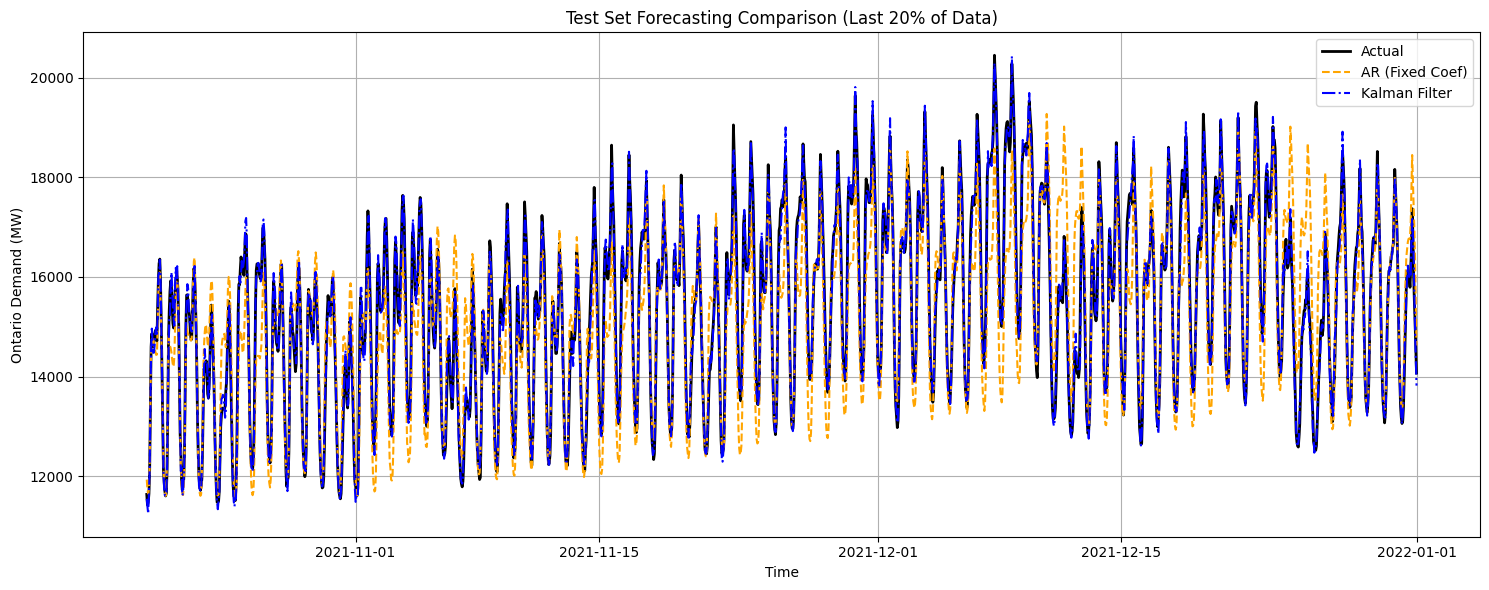

In [155]:
# Plot AR, Kalman, and VIKING forecasts against actuals on test set

plt.figure(figsize=(15, 6))
plt.plot(kf_timestamps, kf_targets, label='Actual', color='black', linewidth=2)
plt.plot(kf_timestamps, preds_all, label='AR (Fixed Coef)', linestyle='--', color='orange')
plt.plot(kf_timestamps, kf_preds, label='Kalman Filter', linestyle='-.', color='blue')
#plt.plot(kf_timestamps, viking_preds, label='VIKING (Simplified)', linestyle=':', color='red')

plt.title("Test Set Forecasting Comparison (Last 20% of Data)")
plt.xlabel("Time")
plt.ylabel("Ontario Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## MLP

In [159]:
# Reload the re-uploaded regional data file
df = pd.read_csv("PUB_DemandZonal_2024.csv", skiprows=3)

df.columns = ['Date', 'Hour', 'Ontario Demand', 'Northwest', 'Northeast', 'Ottawa', 'East',
              'Toronto', 'Essa', 'Bruce', 'Southwest', 'Niagara', 'West', 'Zone Total', 'Diff']
df['Hour'] = df['Hour'].astype(int) - 1
df['Timestamp'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
df.set_index('Timestamp', inplace=True)
df.drop(columns=['Date', 'Hour', 'Zone Total', 'Diff'], inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.asfreq('H')
df.dropna(inplace=True)

# Feature engineering as in the article
df['trend'] = np.linspace(0, 1, len(df))
df['Toy'] = df.index.dayofyear / 365.25
df['weekday'] = df.index.dayofweek
daytype_dummies = pd.get_dummies(df['weekday'], prefix='day')
df['LoadD'] = df['Ontario Demand'].shift(24)
df['LoadW'] = df['Ontario Demand'].shift(24 * 7)
df['Temps95'] = df['Ontario Demand'].ewm(alpha=1-0.95).mean()

# Combine features and drop NA rows
features = pd.concat([df[['trend', 'Toy', 'Temps95', 'LoadD', 'LoadW']], daytype_dummies], axis=1)
target = df['Ontario Demand']
mlp_data = pd.concat([features, target], axis=1).dropna()

# Split data
X = mlp_data.drop(columns='Ontario Demand')
y = mlp_data['Ontario Demand']
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP model
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(15, 10), activation='tanh', max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_preds = mlp.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_absolute_error
mae_mlp_final = mean_absolute_error(y_test, mlp_preds)
mae_mlp_final


/var/folders/8c/z6z6mjx53212d57jbkmyqw640000gn/T/ipykernel_22878/3704883123.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')
/Users/jinchenwang/Desktop/Research/MihaiProject/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


15832.349390957626

In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

X = mlp_data.drop(columns='Ontario Demand')
y = mlp_data['Ontario Demand'].values.reshape(-1, 1)

split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw).ravel()
y_test_scaled = y_scaler.transform(y_test_raw).ravel()

# Define pipeline for MLP with GridSearchCV
mlp_grid = MLPRegressor(max_iter=2000, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(15, 10), (30, 15), (50, 25)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(mlp_grid, param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=0)
grid_search.fit(X_train_scaled, y_train_scaled)

best_mlp = grid_search.best_estimator_

y_pred_scaled = best_mlp.predict(X_test_scaled).reshape(-1, 1)
y_pred_final = y_scaler.inverse_transform(y_pred_scaled).ravel()
y_test_final = y_test_raw.ravel()

# Evaluate
mae_best_mlp = mean_absolute_error(y_test_final, y_pred_final)
grid_search.best_params_, mae_best_mlp


({'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (15, 10)},
 747.1436017050179)

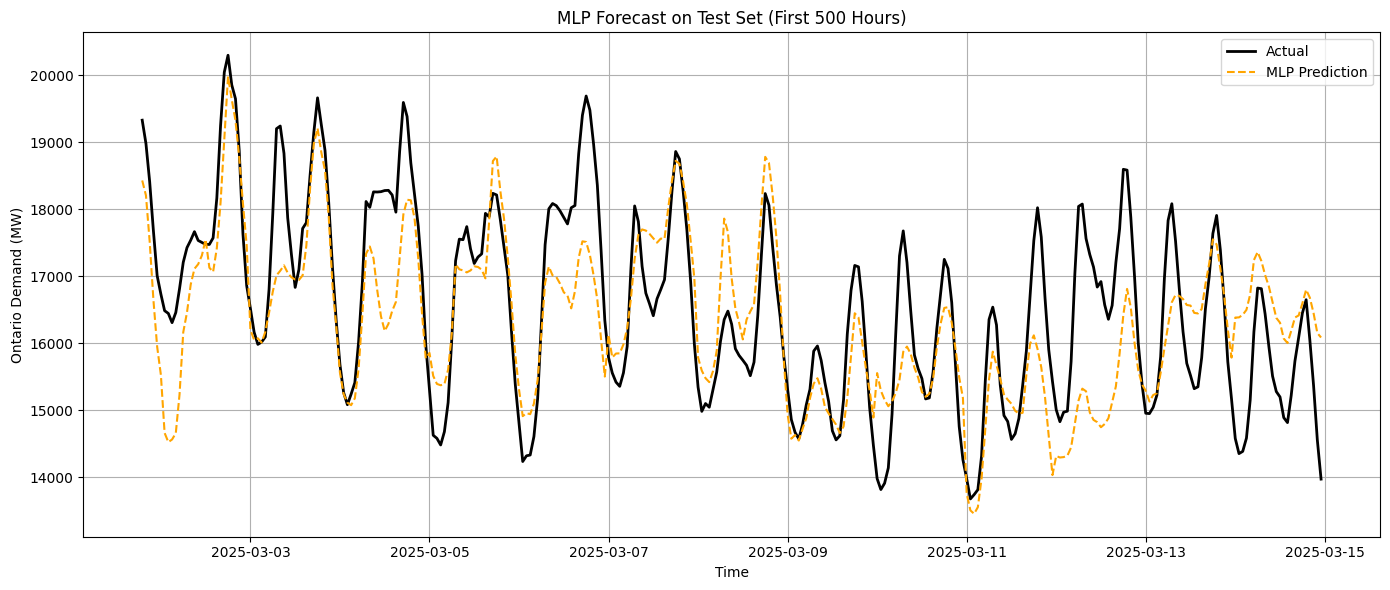

In [162]:
timestamps_test = X_test.index

subset_hours = 500
plt.figure(figsize=(14, 6))
plt.plot(timestamps_test[:subset_hours], y_test_final[:subset_hours], label="Actual", color="black", linewidth=2)
plt.plot(timestamps_test[:subset_hours], y_pred_final[:subset_hours], label="MLP Prediction", linestyle="--", color="orange")
plt.title("MLP Forecast on Test Set (First 500 Hours)")
plt.xlabel("Time")
plt.ylabel("Ontario Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
df = pd.read_csv("PUB_DemandZonal_2025.csv", skiprows=3)
df.columns = ['Date', 'Hour', 'Ontario Demand', 'Northwest', 'Northeast', 'Ottawa', 'East',
              'Toronto', 'Essa', 'Bruce', 'Southwest', 'Niagara', 'West', 'Zone Total', 'Diff']
df['Hour'] = df['Hour'].astype(int) - 1
df['Timestamp'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
df.set_index('Timestamp', inplace=True)
df.drop(columns=['Date', 'Hour', 'Zone Total', 'Diff'], inplace=True)
df = df.apply(pd.to_numeric, errors='coerce').asfreq('H').dropna()

# --- 2. Feature Engineering ---
df['trend'] = np.linspace(0, 1, len(df))
df['Toy'] = df.index.dayofyear / 365.25
df['weekday'] = df.index.dayofweek
df['LoadD'] = df['Ontario Demand'].shift(24)
df['LoadW'] = df['Ontario Demand'].shift(24 * 7)
df['Temps95'] = df['Ontario Demand'].ewm(alpha=1-0.95).mean()
df = pd.concat([df, pd.get_dummies(df['weekday'], prefix='day')], axis=1)
df.dropna(inplace=True)

# --- 3. Prepare Supervised Dataset ---
X = df.drop(columns=['Ontario Demand', 'weekday'])
y = df['Ontario Demand'].values.reshape(-1, 1)

# Scale
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 168  # one week of hourly data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train/test split
split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- 4. Build and Train LSTM Model ---
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# --- 5. Predict and Evaluate ---
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mae_lstm = mean_absolute_error(y_true, y_pred)
print("LSTM MAE:", mae_lstm)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_true[:500], label='Actual', color='black')
plt.plot(y_pred[:500], label='LSTM Prediction', linestyle='--', color='blue')
plt.title(f"LSTM Forecast (First 500 Test Hours) - MAE: {mae_lstm:.2f} MW")
plt.xlabel("Hour")
plt.ylabel("Ontario Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


: 